# Trabajo de investigación: CycleGAN

# Autor: Germán García Estévez

## Contexto Histórico

CycleGAN fue introducido en 2017 por **Jun-Yan Zhu**, **Taesung Park**, **Phillip Isola** y **Alexei A. Efros** en el artículo *"Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks"*.  
  
**Circunstancias y Motivación:**  
- La necesidad de realizar traducciones de imagen a imagen sin disponer de pares exactos de imágenes en ambos dominios (por ejemplo, transformar fotos de caballos en cebras sin tener imágenes correspondientes).

- La innovación principal fue la introducción de la **pérdida de consistencia cíclica (cycle consistency loss)**, que garantiza que la transformación de un dominio a otro y de regreso preserva el contenido esencial de la imagen.

Este enfoque abrió la puerta a numerosos desarrollos en aplicaciones de estilo artístico, transferencia de dominio y mejoras en la generación de imágenes.

## Principales características y comparativa

**Características destacadas de CycleGAN:**

- **Traducción sin datos emparejados:** a diferencia de otros métodos (como Pix2Pix) que requieren pares de imágenes, CycleGAN se entrena con conjuntos de imágenes de cada dominio de forma independiente.

- **Pérdida de consistencia cíclica:** esta pérdida obliga a que una imagen transformada a otro dominio y luego revertida se parezca a la imagen original, lo que ayuda a preservar la identidad de la imagen.

- **Arquitectura dual:** utiliza dos generadores (cada uno para transformar de un dominio al otro) y dos discriminadores que evalúan la calidad de las imágenes generadas en cada dominio.


**Comparativa con otras GAN:**

- **Wasserstein GAN:** se centra en mejorar la estabilidad del entrenamiento y la calidad de las muestras, pero no aborda la traducción de imagen a imagen.

- **Conditional GAN:** aunque permite la generación condicionada, no resuelve directamente el problema de la falta de correspondencia entre dominios como lo hace CycleGAN.

## Arquitectura de CycleGAN

La arquitectura de CycleGAN consta de dos conjuntos de redes:

1. **Generadores (G y F):**

   - **G:** transforma imágenes del dominio X al dominio Y.

   - **F:** realiza la transformación inversa, de Y a X.

   - Ambos generadores suelen estar basados en una arquitectura _encoder-decoder_ con bloques residuales que permiten capturar detalles y mantener la estructura de la imagen.

2. **Discriminadores (D<sub>X</sub> y D<sub>Y</sub>):**
   - Cada discriminador se encarga de distinguir entre imágenes reales y generadas en su dominio respectivo.

   - Usan redes convolucionales que actúan como clasificadores binarios.

**Diagrama:**

<img src="https://drive.google.com/uc?export=view&id=1qzJbQm2Z-AFkCnGy_HDpTirl1uCzS6Rq" width="500" alt="Diagrama">


Esta estructura permite que la red aprenda las transformaciones entre dominios sin perder la información esencial de las imágenes.


## Aplicaciones y casos de uso

- **Transferencia de estilo artístico:** convertir fotos en imágenes con estilos artísticos, por ejemplo, de una foto normal a una pintura al estilo de Van Gogh.

- **Transformación de dominio:** cambiar características visuales (p. ej., transformar caballos en cebras o convertir imágenes de verano en invierno).

- **Mejoras en la fotografía:** eliminación de elementos o modificación de condiciones climáticas en imágenes.

- **Aplicaciones médicas:** posible uso en la mejora o transformación de imágenes médicas entre diferentes modalidades, facilitando la comparación y análisis.

Estos casos de uso demuestran la versatilidad de CycleGAN en múltiples áreas, desde el entretenimiento hasta aplicaciones más técnicas y de investigación.

## Ejemplo práctico. Dataset horse2zebra.

In [1]:
# Descargar el dataset usando gdown
!gdown "https://drive.google.com/uc?id=1TuFdNJGj6n4E76iYFPS5AfRoDhaWBsNa" -O horse2zebra.zip

# Crear la carpeta 'horse2zebra' si no existe
!mkdir -p horse2zebra

# Descomprimir el archivo dentro de la carpeta 'horse2zebra'
!unzip -q horse2zebra.zip -d horse2zebra

Downloading...
From (original): https://drive.google.com/uc?id=1TuFdNJGj6n4E76iYFPS5AfRoDhaWBsNa
From (redirected): https://drive.google.com/uc?id=1TuFdNJGj6n4E76iYFPS5AfRoDhaWBsNa&confirm=t&uuid=243249ef-ea2d-4654-bb32-c6107de1af58
To: /content/horse2zebra.zip
100% 117M/117M [00:05<00:00, 20.1MB/s]


### Creación del dataset

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import time

# Configurar parámetros generales
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 1
EPOCHS = 5  # Se entrenan 5 épocas pues tardan mucho y Colab no deja mucho margen.

# Función para cargar y preprocesar imágenes
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = (image / 127.5) - 1  # Normalizar a [-1, 1]
    return image

# Definir las rutas a las carpetas del dataset (asumiendo que el zip se descomprimió en el directorio actual)
dataset_dir = './horse2zebra'
horse_train_dir = os.path.join(dataset_dir, 'trainA')  # Caballos
zebra_train_dir = os.path.join(dataset_dir, 'trainB')   # Cebras

# Obtener la lista de archivos (se asume que son JPEG)
horse_files = glob.glob(os.path.join(horse_train_dir, '*.jpg'))
zebra_files = glob.glob(os.path.join(zebra_train_dir, '*.jpg'))

print("Número de imágenes de caballos (trainA):", len(horse_files))
print("Número de imágenes de cebras (trainB):", len(zebra_files))

# Crear dos datasets de tf.data a partir de las rutas de imagen
horse_ds = tf.data.Dataset.from_tensor_slices(horse_files)
zebra_ds = tf.data.Dataset.from_tensor_slices(zebra_files)

# Mapear la función de carga y preprocesamiento a cada dataset
horse_ds = horse_ds.map(lambda x: load_image(x), num_parallel_calls=tf.data.AUTOTUNE)
zebra_ds = zebra_ds.map(lambda x: load_image(x), num_parallel_calls=tf.data.AUTOTUNE)

# Mezclar y agrupar en batches
horse_ds = horse_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE)
zebra_ds = zebra_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE)

# Crear el dataset no emparejado (zip)
dataset = tf.data.Dataset.zip((horse_ds, zebra_ds))
dataset = dataset.prefetch(tf.data.AUTOTUNE)

Número de imágenes de caballos (trainA): 1067
Número de imágenes de cebras (trainB): 1334


### Definición de modelos y entrenamiento

In [3]:
# --- Definición de Modelos ---
def resnet_block(input_layer, filters):
    x = layers.Conv2D(filters, kernel_size=3, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, input_layer])
    return x

def build_generator():
    inputs = layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    x = layers.Conv2D(64, kernel_size=7, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    for _ in range(6):
        x = resnet_block(x, 256)
    x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(3, kernel_size=7, padding='same', activation='tanh')(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

def build_discriminator():
    inputs = layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    x = layers.Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(512, kernel_size=4, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(1, kernel_size=4, strides=1, padding='same')(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

# Instanciar modelos:
generator_g = build_generator()  # Transforma caballos en cebras (dominio X -> Y)
generator_f = build_generator()  # Transforma cebras en caballos (dominio Y -> X)
discriminator_x = build_discriminator()  # Discrimina caballos reales y generados
discriminator_y = build_discriminator()  # Discrimina cebras reales y generados

# --- Funciones de Pérdida y Optimizadores ---
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def cycle_consistency_loss(real_image, cycled_image, lambda_cycle=10):
    return lambda_cycle * tf.reduce_mean(tf.abs(real_image - cycled_image))

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = generator_g(real_x, training=True)
        fake_x = generator_f(real_y, training=True)
        cycled_x = generator_f(fake_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        total_cycle_loss = cycle_consistency_loss(real_x, cycled_x) + cycle_consistency_loss(real_y, cycled_y)
        total_gen_g_loss = gen_g_loss + total_cycle_loss
        total_gen_f_loss = gen_f_loss + total_cycle_loss
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

    return total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss

# Bucle de entrenamiento simplificado:
for epoch in range(EPOCHS):
    start = time.time()
    print(f"Época {epoch+1}/{EPOCHS}")
    for n, (real_x, real_y) in dataset.enumerate():
        g_loss, f_loss, d_x_loss, d_y_loss = train_step(real_x, real_y)
        # Imprimir la pérdida de cada batch
        print(f"Batch {n}: Gen_G Loss: {g_loss.numpy():.4f}, Gen_F Loss: {f_loss.numpy():.4f}, "
              f"Disc_X Loss: {d_x_loss.numpy():.4f}, Disc_Y Loss: {d_y_loss.numpy():.4f}")
    print(f"Tiempo para la época {epoch+1}: {time.time()-start:.2f} segundos")

Streaming output truncated to the last 5000 lines.
Batch 344: Gen_G Loss: 8.2888, Gen_F Loss: 7.9748, Disc_X Loss: 0.4353, Disc_Y Loss: 0.5087
Batch 345: Gen_G Loss: 8.1076, Gen_F Loss: 8.2045, Disc_X Loss: 0.6045, Disc_Y Loss: 0.5811
Batch 346: Gen_G Loss: 6.9120, Gen_F Loss: 6.9209, Disc_X Loss: 0.7523, Disc_Y Loss: 0.5925
Batch 347: Gen_G Loss: 8.5466, Gen_F Loss: 8.3358, Disc_X Loss: 0.4121, Disc_Y Loss: 0.5306
Batch 348: Gen_G Loss: 6.3988, Gen_F Loss: 6.7213, Disc_X Loss: 0.4628, Disc_Y Loss: 0.6028
Batch 349: Gen_G Loss: 6.9591, Gen_F Loss: 7.0629, Disc_X Loss: 0.5613, Disc_Y Loss: 0.6373
Batch 350: Gen_G Loss: 7.7281, Gen_F Loss: 7.4488, Disc_X Loss: 0.4765, Disc_Y Loss: 0.5585
Batch 351: Gen_G Loss: 6.6338, Gen_F Loss: 7.0233, Disc_X Loss: 0.5161, Disc_Y Loss: 0.7961
Batch 352: Gen_G Loss: 6.2575, Gen_F Loss: 6.4912, Disc_X Loss: 0.6237, Disc_Y Loss: 0.6674
Batch 353: Gen_G Loss: 6.7875, Gen_F Loss: 6.7937, Disc_X Loss: 0.5692, Disc_Y Loss: 0.4371
Batch 354: Gen_G Loss: 8.6402

## Guardar los modelos

In [5]:
# Crear un directorio para guardar los modelos (si no existe)
save_dir = './saved_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Guardar los modelos en formato H5
generator_g.save(os.path.join(save_dir, 'generator_g.h5'))
generator_f.save(os.path.join(save_dir, 'generator_f.h5'))
discriminator_x.save(os.path.join(save_dir, 'discriminator_x.h5'))
discriminator_y.save(os.path.join(save_dir, 'discriminator_y.h5'))

print("Modelos guardados correctamente en el directorio:", save_dir)

Modelos guardados correctamente en el directorio: ./saved_models


### Visualización de resultados

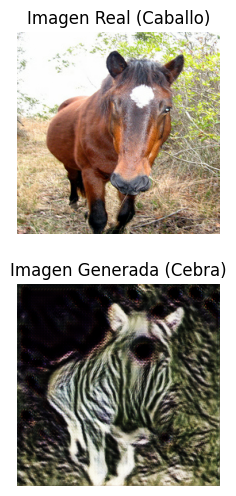

In [18]:
# Función para desnormalizar imágenes (llevar de [-1, 1] a [0, 1])
def denormalize(image):
    image = (image + 1) / 2
    return tf.clip_by_value(image, 0, 1)

# Tomar un batch del dataset para visualizar resultados
for real_x, _ in dataset.take(1):
    fake_y = generator_g(real_x, training=False)
    real_x = denormalize(real_x)
    fake_y = denormalize(fake_y)

    plt.figure(figsize=(12,6))
    for i in range(min(4, real_x.shape[0])):
        plt.subplot(2,4,i+1)
        plt.imshow(real_x[i])
        plt.title("Imagen Real (Caballo)")
        plt.axis('off')

        plt.subplot(2,4,i+5)
        plt.imshow(fake_y[i])
        plt.title("Imagen Generada (Cebra)")
        plt.axis('off')
    plt.show()

## Conclusiones

- **CycleGAN** representa un avance significativo en la traducción de imágenes sin la necesidad de datos emparejados, gracias a la introducción de la pérdida de consistencia cíclica.

- Su arquitectura dual (dos generadores y dos discriminadores) le permite aprender transformaciones complejas entre dominios, manteniendo la estructura esencial de las imágenes.

- Las aplicaciones de CycleGAN son muy variadas, abarcando desde la transferencia de estilos artísticos hasta mejoras en imágenes y aplicaciones médicas.

## Referencias

- Zhu, J.-Y., Park, T., Isola, P., & Efros, A. A. (2017). [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593).
- Tutorial oficial de TensorFlow sobre [CycleGAN](https://www.tensorflow.org/tutorials/generative/cyclegan).
- Foto del diagrama [Diagrama](https://www.researchgate.net/figure/The-Architecture-of-CycleGAN-adopted-from-37_fig5_383575896).